## Analyze A/B Test Results

### By Thu Trang Bui

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head(8)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
treatment_oldpage = df.query('group == "treatment" and landing_page != "new_page"')

In [7]:
control_newpage = df.query('group == "control" and landing_page != "old_page"')

In [8]:
treatment_oldpage.shape[0] + control_newpage.shape[0]

3893

Total number of times when new_page and treatment do not match is 3893. We have to remove these rows from the dataset.

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  We have to remove them from the dataset. 

a. Store new dataframe in **df2**.

In [10]:
df1 = df.drop(treatment_oldpage.index)
df1.shape

(292513, 5)

In [11]:
df2 = df1.drop(control_newpage.index)
df2.shape

(290585, 5)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to drop duplicates.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.user_id.duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [15]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep dataframe as **df2**.

In [16]:
df2 = df2.drop_duplicates(['user_id'], keep='first')

In [17]:
df2.user_id.nunique() == df2.shape[0]

True

`4.` Use **df2** in the cells below to find the probability that an individual receiving the new page.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2[df2['group'] == "control"].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2[df2['group'] == "treatment"].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
(df2.landing_page == "new_page").mean()

0.5000619442226688

e. Consider results from parts (a) through (d) above, and explain below whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.

Firstly, since the probability of an individual receiving the new page is 0.5, i.e. the number of individuals receiving new page and old page is nearly the same. Thus, the weight of each group is balanced and there is no evidence to say that the difference in the metrics is due to the higher probability of receiving one in the two pages by control or treatment group. 
Secondly, based on the results of converted proportion in the two groups control and treatment, there is not sufficient evidence to conclude that the treatment page leads to more conversions than the old page since the probability of conversion for the treatment group is even less than that the control group.
Finally, the difference between the two groups is very small, and requires A/B test to see if this difference is due to chance or not.

<a id='ab_test'></a>
### Part II - A/B Test


`1.` For now, consider that we have to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses are defined as below, with **$p_{old}$** and **$p_{new}$** denoting the converted rates for the old and new pages.

$H_{0}$: $p_{new}$ - $p_{old}$ <= 0;
$H_{1}$: $p_{new}$ - $p_{old}$ > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation. 

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [24]:
# Creat dataframe of the treatment group:
treatment_df = df2.query('group == "treatment"')

In [25]:
# Creat dataframe of the control group:
control_df = df2.query('group == "control"')

In [26]:
# Find the observed statistic, which is the difference in conversion rate between the new rate and the old rate,  in the sample:
obs_diff = treatment_df['converted'].mean() - control_df['converted'].mean()
obs_diff

-0.0015782389853555567

c. What is $n_{new}$, the number of individuals in the treatment group?

In [27]:
n_new = treatment_df.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [28]:
n_old = control_df.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted = treatment_df['converted'].sample(n_new, replace = True)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted = control_df['converted'].sample(n_old, replace = True)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [31]:
new_page_converted.mean() - old_page_converted.mean()

-0.001626333410039385

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [32]:
p_diffs = []

for _ in range(10000):
    new_page_converted = treatment_df['converted'].sample(n_new, replace = True)
    old_page_converted = control_df['converted'].sample(n_old, replace = True)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    
    
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

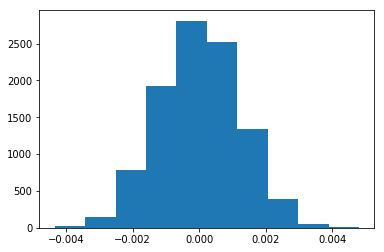

In [34]:
# Use the sampling distribution above to stimulate the distribution under the null hypothesis, by creating 
# a random normal distribution centered at 0 with the same spread and size

p_diffs = np.random.normal(0, p_diffs.std(), p_diffs.size)

plt.hist(p_diffs)
plt.show()

**The plot look like expected, which is the shape of a normal distribution with center at 0.**

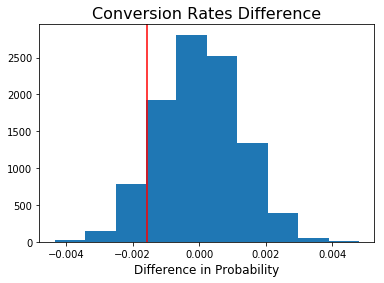

In [35]:
plt.hist(p_diffs)
plt.title("Conversion Rates Difference", fontsize = 16)
plt.xlabel("Difference in Probability", fontsize = 12)
plt.axvline(x = obs_diff, color = 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
(p_diffs > obs_diff).mean()

0.9011

k. Explain p-value.  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The (p_diffs > obs_diff).mean() = 0.901 calculated above is the p-value. It is the probability of getting our statistic if the null hypothesis is true. Compared with the $\alpha$ level of 0.05 (i.e. 5% chance of Type I error if the null is true), if the p-value is smaller than 0.05, we reject the null hypothesis. On the other hand, when the p-value is larger than 0.05, we fail to reject H0. 

In this case, as p-value is 0.901, which is much larger than 0.05, we fail to reject the null hypothesis that there is no difference between new and old pages. Thus, we conclude that there is not sufficient evidence of a difference between the new and old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count() 

n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [38]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Firstly, we see that p-value calculated with the built-in method is 0.905, much larger than 0.05 and confirms the value we calculated before.

Secondly, the z-score calculated is 1.31092419842, which is smaller than 1.96 (with a 95% confidence interval, for a difference to be significant, a z-score needs to be higher than 1.96). So, we fail to reject the null hypothesis that the difference between the two conversion rates is different from zero since the z-score is not outside the critical value.

Finally, the results are in line with the findings in parts j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` The result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Because the dependent variable (the conversion) is a Binary variable when there are only two possible options where we can only choose to be a conversion or no conversion, a logistic regression model needs to be applied.

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. First need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('control', axis = 1)

In [36]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate the regression model on the two columns you created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [40]:
import statsmodels.api as sm

logit_mod = sm.Logit(df2['converted'],df2[['intercept' ,'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of the logistic regression model below:

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:39:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

The p-value of ab_page is 0.190. It is still above an $\alpha$ level of 0.05 but is different from the value found in part II because this is a two tailed test. 

To be detailed, the difference in the p-value of ab_page coefficient in this calculation and the p-value of the A/B test above can be explained as follows:

In the above A/B test, the hypotheses are:

Null hypothesis $H_{0}$: $p_{new}$ - $p_{old}$ <= 0;

Alternative $H_{1}$: $p_{new}$ - $p_{old}$ > 0.

When p-value is smaller than 0.05, it means that the difference between the mean of two probability is significant and not by chance, whilst when p-value is larger than 0.05, we fail to reject null hypothesis and have to accept that there is no difference between the two methods.

In the logistic regression:

Null hypothesis $H_{0}$: coefficient of ab_page = 0;

Alternative $H_{1}$: coefficient of ab_page != 0.

The p-value for the coefficient tests the null hypothesis that the coefficient is equal to zero, i.e. the variable ab_page has no effect on the response variable converted. A low p-value (< 0.05) indicates that we can reject the null hypothesis and it means that the independent variable helps to explain for the dependent variable. In other words, a variable that has a low p-value < 0.05 has a meaningful explanation to your model because changes in this independent variable are related to changes in the response variable. However, in this logistic regression, it can be seen that p-value of ab_page is much larger than 0.05, hence, this variable ab_page has no effects on the converted variable and the changes in the response variable converted is not associated with changes in the page that an individual receives. 

In conclusion, this p-value still suggests that the ab_page has no effect on the conversion, similar to the conclusion from the A/B test.

f. Now, considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into a regression model?

Firstly, adding more predictor variables into a regression model can increase the percentage of the response variable that is explained by the model, i.e. the regression model can explain more about the y variable. Other factors can be personal characteristics of the student (age, background, occupation, country residence, etc.).

However, adding more terms into regression model can come up with some disadvantages, which requires careful analysis to decide if using more predictors is necessary and in general, a model with less predictors and similar explanatory power is better. One disadvantage of adding more predictors is multi-collinearity, i.e. the newly added independent variables are correlated with other independent variables, which is not good because they should be to the model and the coefficients of the variables, which negatively affect the interpretation of the results. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. Read in the **countries.csv** dataset and merge together datasets on the appropriate rows.

Does it appear that country had an impact on conversion?  

In [43]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
country_dummies = pd.get_dummies(df_countries['country'])
df_new = df_countries.join(country_dummies)

In [45]:
df3 = df2.set_index('user_id').join(df_new.set_index('user_id'))

In [46]:
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [47]:
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'US']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 06 Jul 2019   Pseudo R-squ.:               1.521e-05
Time:                        21:42:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

It can be seen that p-values for both countries US and Canada are much larger than a 5% $\alpha$ level. Thus, we fail to reject the null hypothesis that the coefficients are different from zero. In other words, we have to conclude that the countries have no significant contribution to the differences in conversion rates of two pages.

h. We would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model. 

In [48]:
df3['CA_page'] = df3['CA'] * df3['ab_page']
df3['US_page'] = df3['US'] * df3['ab_page']
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_page,US_page
user_id,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [49]:
logit = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'US', 'ab_page', 'CA_page', 'US_page']])
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 06 Jul 2019   Pseudo R-squ.:               3.482e-05
Time:                        21:43:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA_page       -0.0783      0.057     -1.378      0.168      -0.190       0.033
US_page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

In the last regression model, the explanatory variables are the countries CA, US, the ab_page, and the interaction between them: CA_page, US_page. As can be seen from the summary table, all of these variables have high p-values, i.e. we fail to reject the null hypothesis that the coefficients are different from zero and conclude that both the countries variables, the page variable, and also the interaction between country and page do not help to predict that an individual will convert or not.


## Conclusions

Finally, to conclude the whole project, there is no sufficient evidence to say that a new page works better than an old page in affecting the decision of a user to convert or not. Therefore, with the current dataset, the company can consider keeping the old page or running the experiment longer to make their decision in the future.